In [1]:
%cd ..

/home/ltorres/leo/tesis/cloud-classification/code


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

In [4]:
torch.manual_seed(7)
np.random.seed(7)

In [5]:
import os
from torchvision.io import read_image
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx

In [6]:
from src import config
from src import engine
from src import utils

In [11]:
from recipe.utils import *

In [8]:
torch.manual_seed(7)
np.random.seed(7)

### Dataloaders

In [22]:
path_train_images = utils.get_gcd_paths(config.DATA_DIR,'train')

train_dataset = GCD(path_train_images, resize=256)

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=16,
        num_workers=6,
        shuffle=True,
    )

In [23]:
path_test_images = utils.get_gcd_paths(config.DATA_DIR,'test')

test_dataset = GCD(path_test_images, resize=256)

test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=16,
        num_workers=6,
        shuffle=True,
    )

#### ✅ Overfit a batch

In [11]:
batch = next(iter(train_loader))

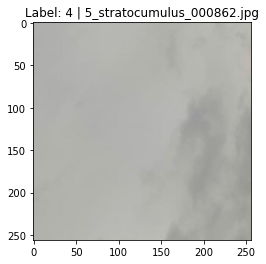

In [12]:
idx = 9

sample = batch['images'][idx].numpy().transpose(2,1,0)
sample = (sample*70.5983+155.5673).astype(int)

plt.title(f"Label: {batch['targets'][idx].item()} | {batch['paths'][idx]}")
plt.imshow(sample)
plt.show()

In [18]:
device = 'cuda:2'
EPOCHS = 100
LR = 3e-4

In [14]:
model = GraphClassifier(7).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


model.train()

losses = []

### batch setup
batch['images'] = batch['images'].to(device)
batch['targets'] = batch['targets'].to(device)

for e in range(EPOCHS):
    logits = model(batch['images'])
    
    optimizer.zero_grad()
    loss = criterion(logits, batch['targets'])
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if e%100 == 0:
        print(f"EPOCH {e+1} LOSS: {loss.item()}")
    

EPOCH 1 LOSS: 2.275038480758667


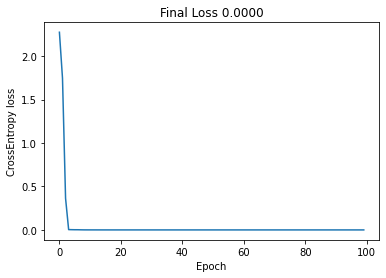

In [15]:
plt.title(f'Final Loss {losses[-1]:.4f}')
pd.Series(losses).plot.line()
plt.ylabel('CrossEntropy loss')
plt.xlabel('Epoch')
plt.show()

#### Visualize

In [16]:
model.eval()
with torch.no_grad():
    logits = model(batch['images'])
    preds = torch.argmax(F.softmax(logits,1),1)

In [17]:
images = batch['images'].cpu().numpy().transpose(0,3,2,1)
images = (images*70.5983 + 155.5673).astype(int)

targets = batch['targets'].cpu().numpy()
predictions = preds.cpu().numpy()

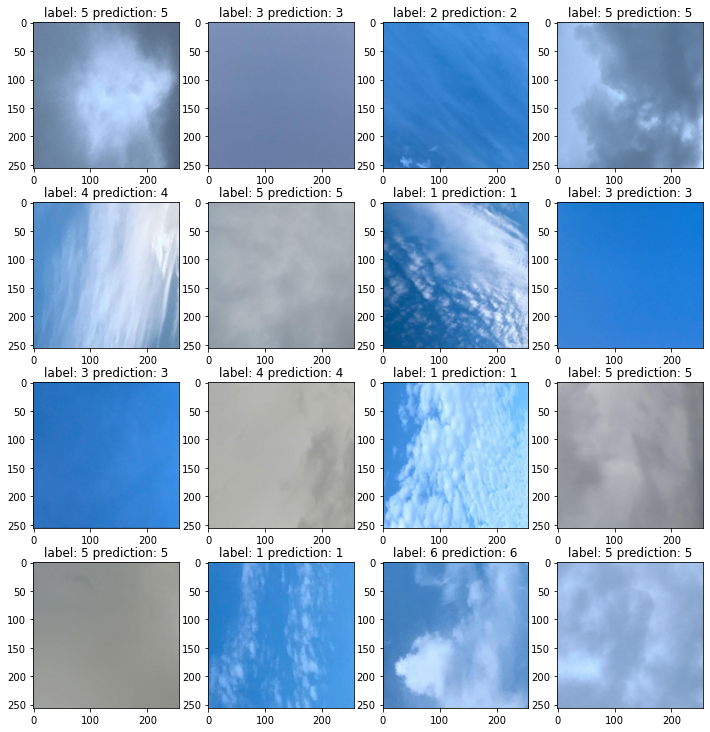

In [18]:
fig = plt.figure(figsize=(12, 16))
columns = 4
rows = 5
for i in range(1, targets.shape[0] +1):
    img = images[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.title(f'label: {targets[i-1]} prediction: {predictions[i-1]}')
plt.show()

In [14]:
adjacency = model.get_adjacency_matrix(batch['images'])

NameError: name 'model' is not defined

In [20]:
G = nx.from_numpy_matrix(adjacency.numpy(), create_using=nx.Graph)

plt.figure(1,figsize=(7,5)) 
nx.draw(G, nx.spring_layout(G, k=10/np.sqrt(G.number_of_nodes())), with_labels=True, node_color=batch['targets'].cpu().numpy(), font_color="white", font_weight="bold")
plt.title('Grafo de representacion de imagenes de nubes')
plt.show()

AttributeError: 'tuple' object has no attribute 'numpy'

### Train con todo el batch

In [19]:
device='cuda:3'

In [26]:
from sklearn.metrics import accuracy_score

In [27]:
model = GraphClassifier2(7).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)


train_losses = []
test_losses = []


for e in range(20):
    train_predictions, train_targets, train_loss = train(model, train_loader, criterion, optimizer, device)
    test_predictions, test_targets, test_loss = test(model, test_loader, criterion, device)
    
    train_acc = accuracy_score(train_targets, train_predictions)
    test_acc = accuracy_score(test_targets, test_predictions)
    
    print("EPOCH {}: Train acc: {:.2%} Train Loss: {:.4f} Test acc: {:.2%} Test Loss: {:.4f}".format(
        e+1,
        train_acc,
        train_loss,
        test_acc,
        test_loss
    ))
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    

100%|██████████| 563/563 [00:18<00:00, 30.23it/s]


EPOCH 1: Train acc: 78.54% Train Loss: 0.5786 Test acc: 71.31% Test Loss: 1.0106


100%|██████████| 563/563 [00:18<00:00, 30.30it/s]


EPOCH 2: Train acc: 85.85% Train Loss: 0.3663 Test acc: 74.02% Test Loss: 0.8913


100%|██████████| 563/563 [00:18<00:00, 30.34it/s]


EPOCH 3: Train acc: 88.33% Train Loss: 0.3007 Test acc: 74.14% Test Loss: 0.9195


100%|██████████| 563/563 [00:18<00:00, 30.27it/s]


EPOCH 4: Train acc: 90.51% Train Loss: 0.2453 Test acc: 72.38% Test Loss: 1.0226


100%|██████████| 563/563 [00:18<00:00, 30.18it/s]


EPOCH 5: Train acc: 91.52% Train Loss: 0.2165 Test acc: 74.09% Test Loss: 1.0040


100%|██████████| 563/563 [00:18<00:00, 30.38it/s]


EPOCH 6: Train acc: 92.38% Train Loss: 0.1932 Test acc: 73.88% Test Loss: 0.9878


100%|██████████| 563/563 [00:18<00:00, 30.23it/s]


EPOCH 7: Train acc: 93.95% Train Loss: 0.1588 Test acc: 73.80% Test Loss: 1.0597


100%|██████████| 563/563 [00:18<00:00, 30.22it/s]


EPOCH 8: Train acc: 94.87% Train Loss: 0.1321 Test acc: 73.86% Test Loss: 1.1000


100%|██████████| 563/563 [00:18<00:00, 30.24it/s]


EPOCH 9: Train acc: 94.96% Train Loss: 0.1256 Test acc: 72.63% Test Loss: 1.2718


100%|██████████| 563/563 [00:18<00:00, 30.20it/s]


EPOCH 10: Train acc: 96.17% Train Loss: 0.1036 Test acc: 73.52% Test Loss: 1.2399


100%|██████████| 563/563 [00:18<00:00, 30.30it/s]


EPOCH 11: Train acc: 96.46% Train Loss: 0.0963 Test acc: 73.30% Test Loss: 1.2020


100%|██████████| 563/563 [00:18<00:00, 30.18it/s]


EPOCH 12: Train acc: 97.01% Train Loss: 0.0843 Test acc: 73.70% Test Loss: 1.2579


100%|██████████| 563/563 [00:18<00:00, 30.21it/s]


EPOCH 13: Train acc: 97.56% Train Loss: 0.0690 Test acc: 74.10% Test Loss: 1.2389


100%|██████████| 563/563 [00:18<00:00, 30.13it/s]


EPOCH 14: Train acc: 97.66% Train Loss: 0.0645 Test acc: 73.76% Test Loss: 1.3184


100%|██████████| 563/563 [00:18<00:00, 30.16it/s]


EPOCH 15: Train acc: 97.95% Train Loss: 0.0584 Test acc: 74.02% Test Loss: 1.3923


100%|██████████| 563/563 [00:18<00:00, 30.19it/s]


EPOCH 16: Train acc: 98.35% Train Loss: 0.0498 Test acc: 74.37% Test Loss: 1.4279


100%|██████████| 563/563 [00:18<00:00, 30.29it/s]


EPOCH 17: Train acc: 98.60% Train Loss: 0.0429 Test acc: 73.92% Test Loss: 1.5508


100%|██████████| 563/563 [00:18<00:00, 30.14it/s]


EPOCH 18: Train acc: 98.75% Train Loss: 0.0375 Test acc: 73.62% Test Loss: 1.6228


100%|██████████| 563/563 [00:18<00:00, 30.14it/s]


EPOCH 19: Train acc: 98.89% Train Loss: 0.0326 Test acc: 74.31% Test Loss: 1.4366


100%|██████████| 563/563 [00:18<00:00, 30.32it/s]

EPOCH 20: Train acc: 98.62% Train Loss: 0.0380 Test acc: 73.34% Test Loss: 1.5795


In [110]:
path_test_images = utils.get_gcd_paths(config.DATA_DIR,'test')

test_dataset = GCD(path_test_images, resize=256)

test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=16,
        num_workers=6,
        shuffle=False,
    )

In [111]:
with torch.no_grad():
    test_predictions, test_targets, test_loss = test(model, test_loader, criterion, device)
    test_acc = accuracy_score(test_targets, test_predictions)
    
print('TEST_ACC: {:.4%}'.format(test_acc))
    

100%|██████████| 563/563 [00:18<00:00, 30.28it/s]

TEST_ACC: 78.3889%


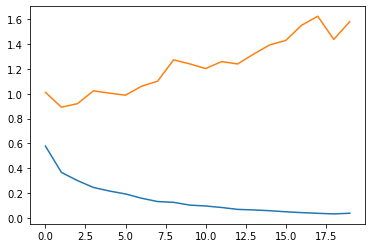

In [28]:
pd.Series(train_losses).plot.line()
pd.Series(test_losses).plot.line()
plt.show()

In [29]:
torch.save(model.state_dict(), 'recipe/graph_params2.pt')

---

In [30]:
from sklearn.metrics import accuracy_score

## EXPERIMENTO 1: Batch aleatorio de test (threshold 0.72, 0.70)

In [112]:
device='cuda:3'

In [113]:
model = GraphClassifier2(7).to(device)
model.load_state_dict(torch.load('recipe/graph_params2.pt'))

<All keys matched successfully>

In [114]:
path_train_images = utils.get_gcd_paths(config.DATA_DIR,'train')

train_dataset = GCD(path_train_images, resize=256)

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=16,
        num_workers=6,
        shuffle=True,
    )

path_test_images = utils.get_gcd_paths(config.DATA_DIR,'test')

test_dataset = GCD(path_test_images, resize=256)

test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=16,
        num_workers=6,
        shuffle=True,
    )

In [115]:
batch_train = iter(train_loader).next()
batch_test = iter(test_loader).next()

In [116]:
batch_eval = batch_test

In [117]:
# ### PRUEBA
# batch_eval= {}
# batch_eval['images'] = torch.cat([batch_train['images'], batch_test['images']],dim=0)
# batch_eval['targets'] = torch.cat([batch_train['targets'], batch_test['targets']],dim=0)


In [118]:
batch_eval['targets']

tensor([5, 2, 4, 2, 3, 6, 2, 1, 5, 4, 4, 4, 5, 3, 4, 5])

In [119]:
model.eval()
with torch.no_grad():
    logits = model(batch_eval['images'].to(device))
    probs = F.softmax(logits,1)
    preds = torch.argmax(probs,1).cpu()
    adjacency, similarity = model.get_adjacency_matrix(batch_eval['images'].to(device))

In [120]:
accuracy_score(batch_eval['targets'], preds)

0.625

In [121]:
sparsity = 1 - len(torch.where(adjacency)[0])/(adjacency.shape[0]**2)

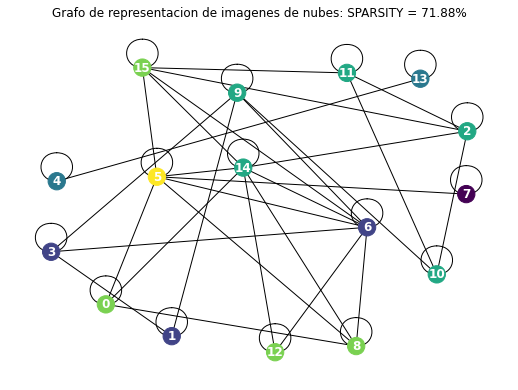

In [122]:
G = nx.from_numpy_matrix(adjacency.numpy(), create_using=nx.Graph)

plt.figure(1,figsize=(7,5)) 
nx.draw(G, nx.spring_layout(G, k=10/np.sqrt(G.number_of_nodes())), with_labels=True, node_color=batch_eval['targets'].cpu().numpy(), font_color="white", font_weight="bold")
plt.title('Grafo de representacion de imagenes de nubes: SPARSITY = {:.2%}'.format(sparsity))
plt.show()

In [123]:
idx = 5

In [124]:
torch.where(adjacency[idx])

(tensor([ 0,  5,  6,  7,  8, 14, 15]),)

In [125]:
similarity[idx][torch.where(adjacency[idx])]

tensor([0.7315, 1.0000, 0.7477, 0.7198, 0.7798, 0.7082, 0.7132])

In [126]:
preds[torch.where(adjacency[idx])]

tensor([4, 4, 5, 5, 4, 5, 5])

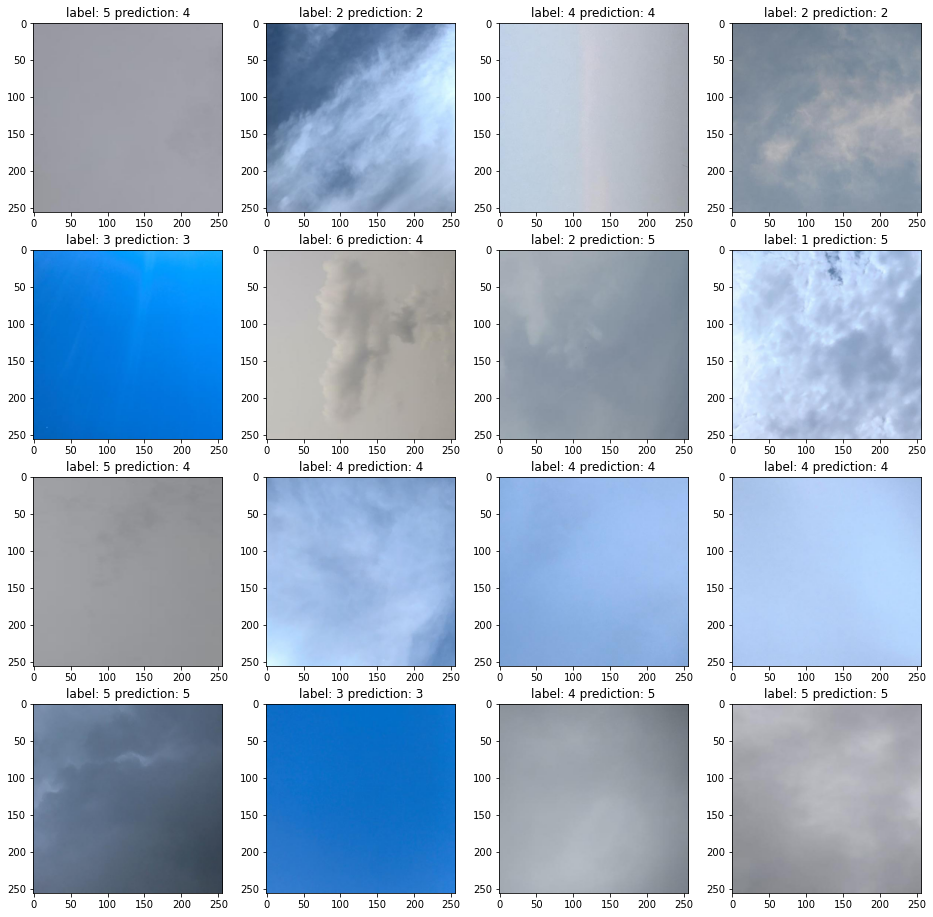

In [127]:
images = batch_eval['images'].cpu().numpy().transpose(0,3,2,1)
images = (images*70.5983 + 155.5673).astype(int)

targets = batch_eval['targets'].cpu().numpy()
predictions = preds.cpu().numpy()

fig = plt.figure(figsize=(16, 16))
columns = 4
rows = 4
for i in range(1, targets.shape[0] +1):
    img = images[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.title(f'label: {targets[i-1]} prediction: {predictions[i-1]}')
plt.savefig('recipe/batch_predictions_0.70.png')
plt.show()



---

## EXPERIMENTO 2: Banco de imagenes

In [54]:
paths = [
    '/data/mandonaire/GCD/train/1_cumulus/1_cumulus_000082.jpg',
    '/data/mandonaire/GCD/train/1_cumulus/1_cumulus_000127.jpg',
    '/data/mandonaire/GCD/train/2_altocumulus/2_altocumulus_000003.jpg',
    '/data/mandonaire/GCD/train/2_altocumulus/2_altocumulus_000028.jpg',
    '/data/mandonaire/GCD/train/3_cirrus/3_cirrus_000035.jpg',
    '/data/mandonaire/GCD/train/3_cirrus/3_cirrus_000115.jpg',
    '/data/mandonaire/GCD/train/4_clearsky/4_clearsky_000004.jpg',
    '/data/mandonaire/GCD/train/4_clearsky/4_clearsky_000055.jpg',
    '/data/mandonaire/GCD/train/5_stratocumulus/5_stratocumulus_000003.jpg',
    '/data/mandonaire/GCD/train/5_stratocumulus/5_stratocumulus_000069.jpg',
    '/data/mandonaire/GCD/train/6_cumulonimbus/6_cumulonimbus_000011.jpg',
    '/data/mandonaire/GCD/train/6_cumulonimbus/6_cumulonimbus_000059.jpg',
    '/data/mandonaire/GCD/train/7_mixed/7_mixed_000006.jpg',
    '/data/mandonaire/GCD/train/7_mixed/7_mixed_000039.jpg',
]

In [55]:
train_dataset_sample = GCD(paths, resize=256)

train_loader_sample = torch.utils.data.DataLoader(
        train_dataset_sample,
        batch_size=14,
        num_workers=6,
        shuffle=False,
    )

In [56]:
batch_sample = iter(train_loader_sample).next()

In [57]:
model.eval()
with torch.no_grad():
    logits = model(batch_sample['images'].to(device))
    probs = F.softmax(logits,1)
    preds = torch.argmax(probs,1).cpu()
    adjacency, similarity = model.get_adjacency_matrix(batch_sample['images'].to(device))

In [58]:
accuracy_score(batch_sample['targets'], preds)

1.0

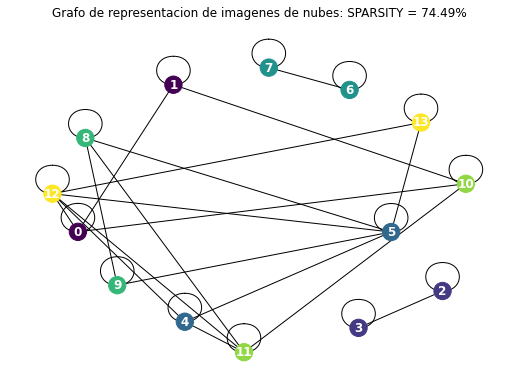

In [59]:
sparsity = 1 - len(torch.where(adjacency)[0])/(adjacency.shape[0]**2)

G = nx.from_numpy_matrix(adjacency.numpy(), create_using=nx.Graph)

plt.figure(1,figsize=(7,5)) 
nx.draw(G, nx.spring_layout(G, k=10/np.sqrt(G.number_of_nodes())), with_labels=True, node_color=batch_sample['targets'].cpu().numpy(), font_color="white", font_weight="bold")
plt.title('Grafo de representacion de imagenes de nubes: SPARSITY = {:.2%}'.format(sparsity))
plt.show()

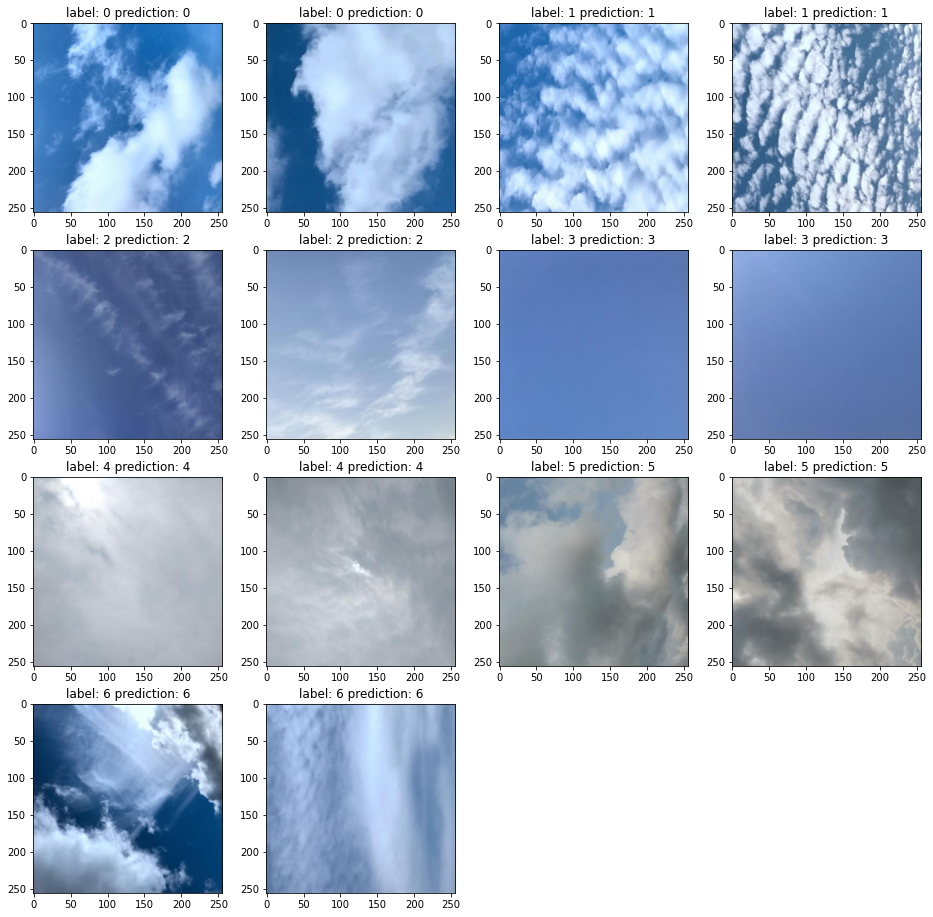

In [60]:
images = batch_sample['images'].cpu().numpy().transpose(0,3,2,1)
images = (images*70.5983 + 155.5673).astype(int)

targets = batch_sample['targets'].cpu().numpy()
predictions = preds.cpu().numpy()

fig = plt.figure(figsize=(16, 16))
columns = 4
rows = 4
for i in range(1, targets.shape[0] +1):
    img = images[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.title(f'label: {targets[i-1]} prediction: {predictions[i-1]}')
plt.savefig('recipe/batch_predictions_0.70.png')
plt.show()



#### Prueba con imagen 1

In [72]:
idx = 8

In [73]:
images = torch.cat([batch_sample['images'], batch_test['images'][idx].unsqueeze(0)],dim=0)
targets = torch.cat([batch_sample['targets'], batch_test['targets'][idx].unsqueeze(0)],dim=0)

In [74]:
model.eval()
with torch.no_grad():
    logits = model(images.to(device))
    probs = F.softmax(logits,1)
    preds = torch.argmax(probs,1).cpu()
    adjacency, similarity = model.get_adjacency_matrix(images.to(device))

In [75]:
adjacency.shape

torch.Size([15, 15])

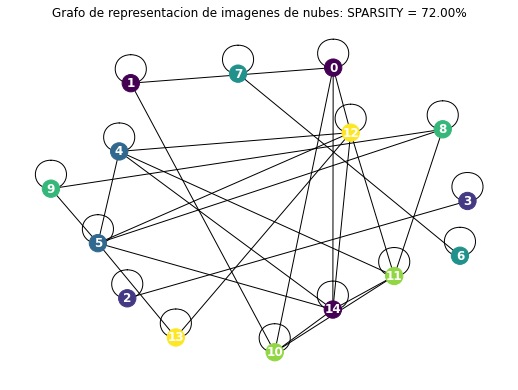

In [76]:
sparsity = 1 - len(torch.where(adjacency)[0])/(adjacency.shape[0]**2)

G = nx.from_numpy_matrix(adjacency.numpy(), create_using=nx.Graph)

plt.figure(1,figsize=(7,5)) 
nx.draw(G, nx.spring_layout(G, k=10/np.sqrt(G.number_of_nodes())), with_labels=True, node_color=targets.cpu().numpy(), font_color="white", font_weight="bold")
plt.title('Grafo de representacion de imagenes de nubes: SPARSITY = {:.2%}'.format(sparsity))
plt.show()

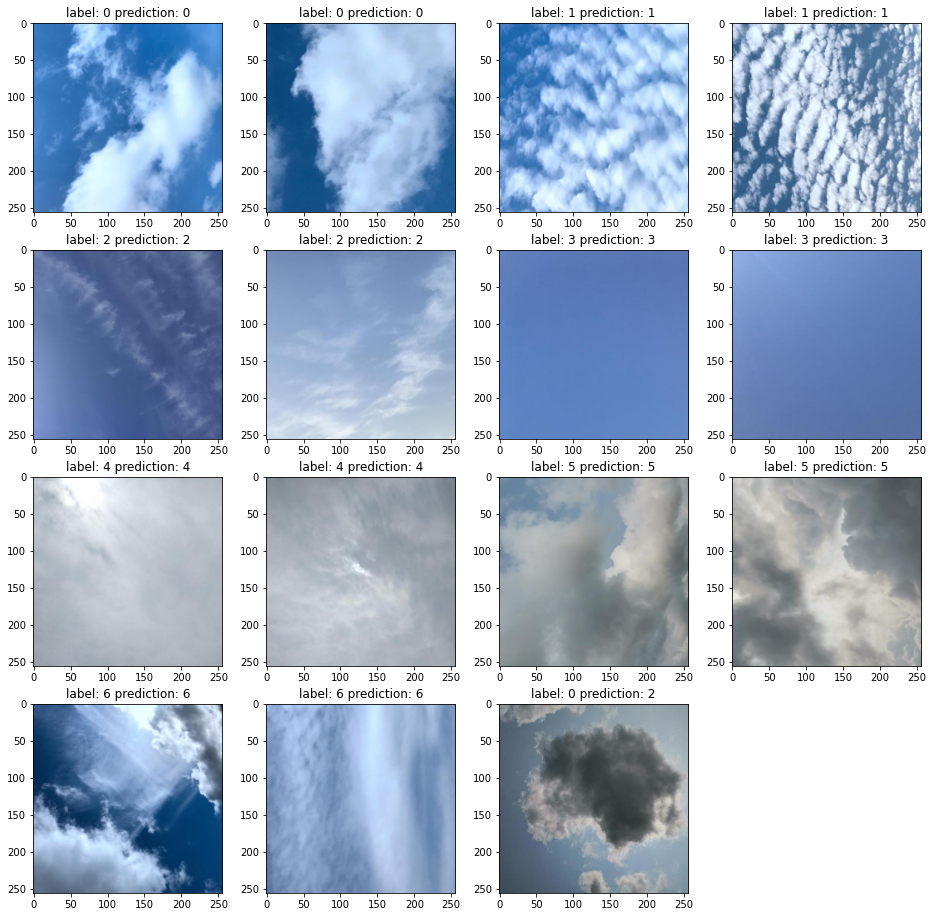

In [77]:
images = images.cpu().numpy().transpose(0,3,2,1)
images = (images*70.5983 + 155.5673).astype(int)

targets = targets.cpu().numpy()
predictions = preds.cpu().numpy()

fig = plt.figure(figsize=(16, 16))
columns = 4
rows = 4
for i in range(1, targets.shape[0] +1):
    img = images[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.title(f'label: {targets[i-1]} prediction: {predictions[i-1]}')
plt.savefig('recipe/batch_predictions_0.70.png')
plt.show()

In [78]:
criterion2 = nn.CrossEntropyLoss(reduction='none')

In [79]:
gnn_losses = list()
gnn_predictions = list()

for i, pred_img in enumerate(batch_test['images']):
    pred_img = pred_img.unsqueeze(0)
    images = torch.cat([batch_sample['images'], pred_img],dim=0)
    targets = torch.cat([batch_sample['targets'], batch_test['targets'][i].unsqueeze(0)],dim=0)
    
    logits = model(images.to(device))
    probs = F.softmax(logits,1)
    preds = torch.argmax(probs,1).cpu()
    
    gnn_losses.append(criterion2(logits, targets.to(device))[-1].item())
    gnn_predictions.append(preds[-1].item())

In [80]:
gnn_losses

[5.960446742392378e-06,
 2.7367851734161377,
 6.151010165922344e-05,
 0.0035761946346610785,
 1.1444026313256472e-05,
 5.793282508850098,
 -0.0,
 5.006777428206988e-06,
 7.159439563751221,
 2.8967437174287625e-05,
 0.08220311999320984,
 0.0010401559993624687,
 0.26425090432167053,
 0.0015814905054867268,
 1.1920928244535389e-07,
 -0.0]

In [81]:
np.argmax(gnn_losses)

8

In [82]:
accuracy_score(gnn_predictions, batch_test['targets'])

0.8125

---

## EXPERIMETO 3: Con TODO EL GRAFO DE TRAIN

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
df_sample_data = pd.DataFrame({'path': path_train_images, 'target': train_dataset.targets})

In [24]:
_, df_big_sample = train_test_split(df_sample_data, test_size=0.06, random_state=42, stratify=df_sample_data['target'].values)

In [25]:
big_paths = df_big_sample['path'].tolist()

In [26]:
big_train_dataset = GCD(big_paths, resize=256)

big_train_loader = torch.utils.data.DataLoader(
        big_train_dataset,
        batch_size=32,
        num_workers=6,
        shuffle=False,
    )

In [27]:
train_images = []

In [28]:
model.eval()
with torch.no_grad():
    for i, data in enumerate(big_train_loader):
        train_images.append(data['images'])
        

In [29]:
train_images = torch.cat(train_images, dim=0)

In [30]:
train_images.shape

torch.Size([600, 3, 256, 256])

In [32]:
model = model.cpu()

In [33]:
device='cpu'

In [ ]:
gnn_losses = list()
gnn_predictions = list()

for i, pred_img in enumerate(batch_test['images']):
    pred_img = pred_img.unsqueeze(0)
    images = torch.cat([train_images, pred_img],dim=0)
    
    logits = model(images.to(device))
    
    probs = F.softmax(logits,1)
    preds = torch.argmax(probs,1).cpu()
    
    gnn_losses.append(criterion2(logits[-1], batch_test['targets'][-1].to(device))[-1].item())
    gnn_predictions.append(preds[-1].item())

In [ ]:
accuracy_score(gnn_predictions, batch_test['targets'])